=== Summary Statistics ===
       Global_active_power  Global_reactive_power        Voltage  \
count        103640.000000          103640.000000  103640.000000   
mean              1.204582               0.125108     239.056833   
std               1.184427               0.112474       3.658287   
min               0.096000               0.000000     224.620000   
25%               0.308000               0.000000     236.350000   
50%               0.672000               0.106000     239.530000   
75%               1.666000               0.194000     241.810000   
max              10.670000               0.986000     250.020000   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count     103640.000000   103640.000000   103640.000000   103640.000000  
mean           5.138283        1.281455        1.692956        6.066316  
std            5.007758        6.551113        6.825293        8.260284  
min            0.400000        0.000000        0.000000        0

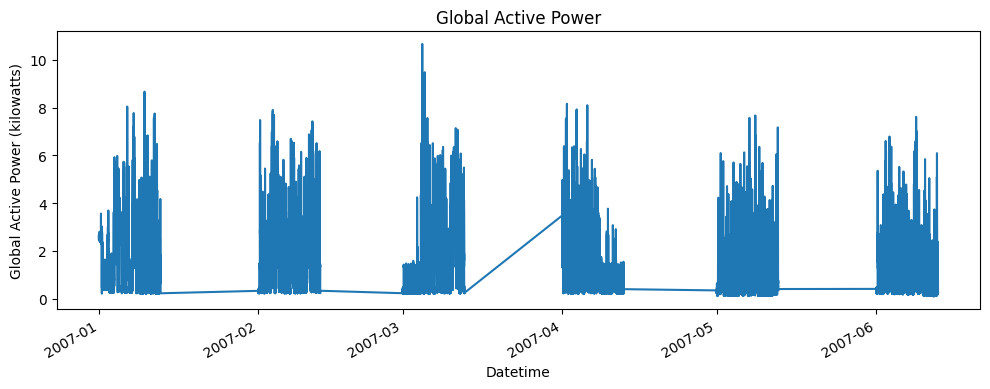

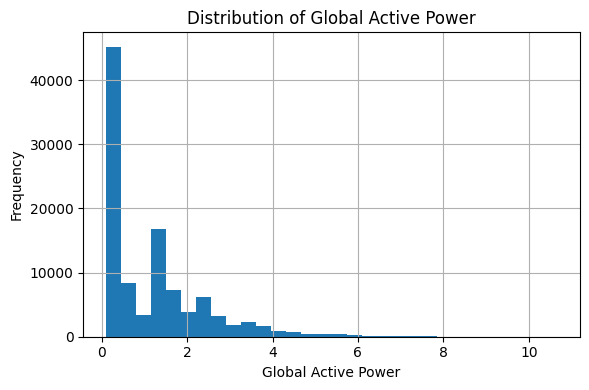

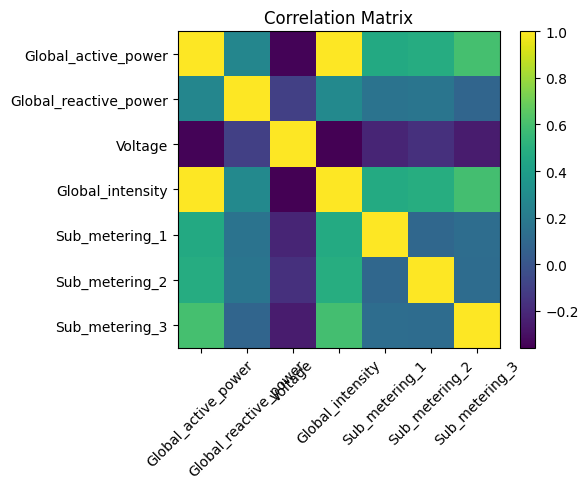

As the corelation between Global_active_power and Global_intensity is near to 1, we are dropping Global_Intensity


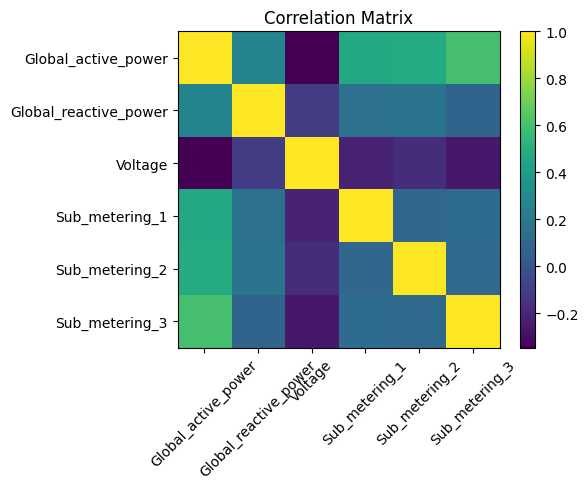

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import shap

# 1) Load the entire dataset
path = "/kaggle/input/powerconsumption/household_power_consumption.csv"
df = pd.read_csv(path, sep=',', na_values='?')


# 2) Drop the 'index' column 
if 'index' in df.columns:
    df.drop(columns=['index'], inplace=True)

# 3) Strip whitespace from column names (just in case)
df.columns = df.columns.str.strip()

# 4) Combine Date & Time into a single Datetime index
df['Datetime'] = pd.to_datetime(
    df['Date'].str.strip() + ' ' + df['Time'].str.strip(),
    format='%d/%m/%y %H:%M:%S',
    dayfirst=True,
    errors='coerce'
)
df.dropna(subset=['Datetime'], inplace=True)
df.set_index('Datetime', inplace=True)
df.drop(columns=['Date', 'Time'], inplace=True)

# 5) Convert measurement columns to numeric, drop any rows with NaNs
numeric_cols = [
    'Global_active_power','Global_reactive_power','Voltage',
    'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3'
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=numeric_cols, inplace=True)

# 6) Exploratory Data Analysis
#   a) Quick summary statistics
print("=== Summary Statistics ===")
print(df[numeric_cols].describe(), "\n")

#   b) Missing-value check
print("=== Missing Values (should be zero as we already handled them) ===")
print(df[numeric_cols].isna().sum(), "\n")

#   c) Time series plot of Global_active_power
plt.figure(figsize=(10, 4))
df['Global_active_power'].plot(title='Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatts)')
plt.tight_layout()
plt.show()

#   d) Distribution histogram
plt.figure(figsize=(6, 4))
df['Global_active_power'].hist(bins=30)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#   e) Correlation matrix heatmap
corr = df[numeric_cols].corr()
plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# 6f) Drop the highly-collinear column 
df.drop(columns=['Global_intensity'], inplace=True)
print("As the corelation between Global_active_power and Global_intensity is near to 1, we are dropping Global_Intensity")

# Correlation matrix heatmap after the changes
new_numeric_cols = [
    'Global_active_power','Global_reactive_power','Voltage',
    'Sub_metering_1','Sub_metering_2','Sub_metering_3'
]
corr = df[new_numeric_cols].corr()
plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# 7) Feature engineering
df['hour']      = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month']     = df.index.month
df['lag1']      = df['Global_active_power'].shift(1)
df['lag24']     = df['Global_active_power'].shift(24)
df['rolling_3h']= df['Global_active_power'].rolling(3, min_periods=1).mean()
df.dropna(inplace=True)

# 8) Scaling
scaler = StandardScaler()
features = [
    'Global_reactive_power','Voltage',
    # 'Global_intensity',    # ← dropped
    'Sub_metering_1','Sub_metering_2','Sub_metering_3',
    'hour','dayofweek','month','lag1','lag24','rolling_3h'
]
df[features] = scaler.fit_transform(df[features])

# 9) Time-series train/test split
tscv = TimeSeriesSplit(n_splits=3)
train_idx, test_idx = next(tscv.split(df))
X_train = df.iloc[train_idx][features]
X_test  = df.iloc[test_idx][features]
y_train = df.iloc[train_idx]['Global_active_power']
y_test  = df.iloc[test_idx]['Global_active_power']


XGBoost RMSE: 0.2153
XGBoost R²:   0.9729


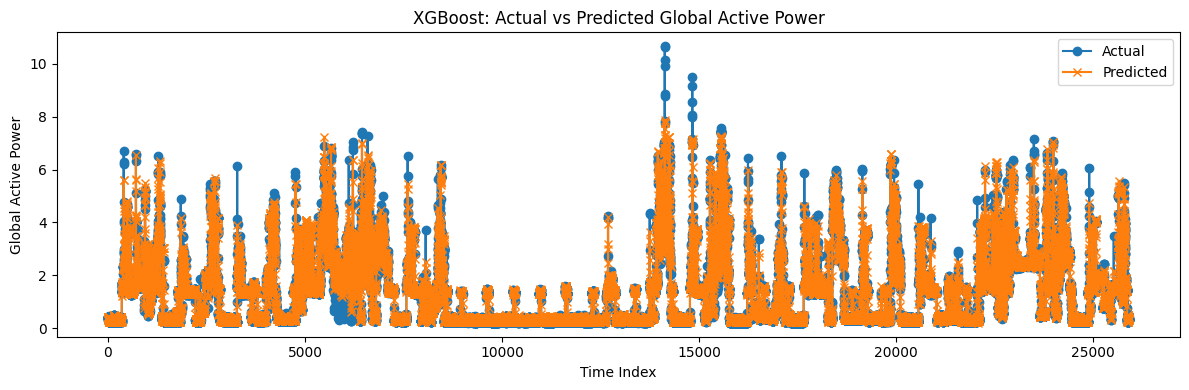

In [7]:
# 10) Train an XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 11) Predict and evaluate
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2  = r2_score(y_test, y_pred)
print(f"XGBoost RMSE: {rmse:.4f}")
print(f"XGBoost R²:   {r2:.4f}")

# 12) Plot actual vs. predicted
plt.figure(figsize=(12, 4))
plt.plot(y_test.values,       marker='o', label='Actual')
plt.plot(y_pred,              marker='x', label='Predicted')
plt.title('XGBoost: Actual vs Predicted Global Active Power')
plt.xlabel('Time Index')
plt.ylabel('Global Active Power')
plt.legend()
plt.tight_layout()
plt.show()

PermutationExplainer explainer: 25905it [28:03, 15.29it/s]                           


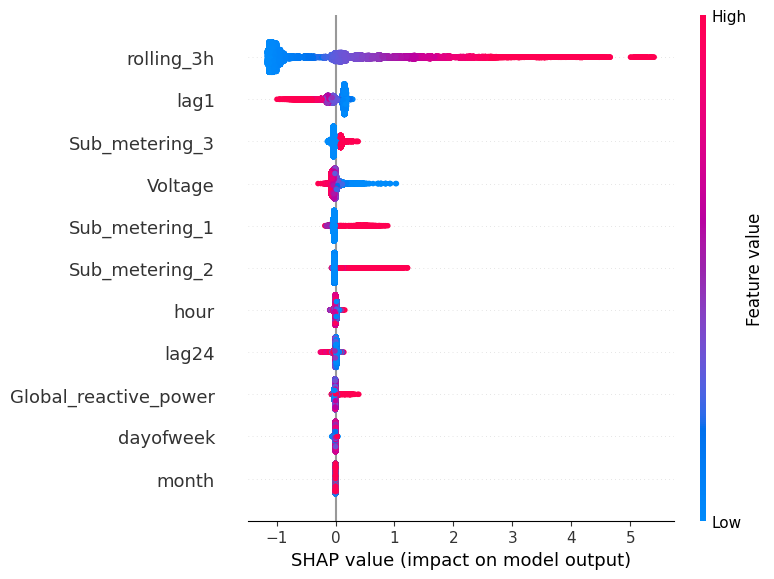

In [8]:
#shap
# Fits the explainer
explainer = shap.Explainer(xgb_model.predict, X_test)
# Calculates the SHAP values
shap_values = explainer(X_test)
# Plot summary
shap.summary_plot(shap_values, X_test)

Random Forest RMSE: 0.2370
Random Forest R²:   0.9672


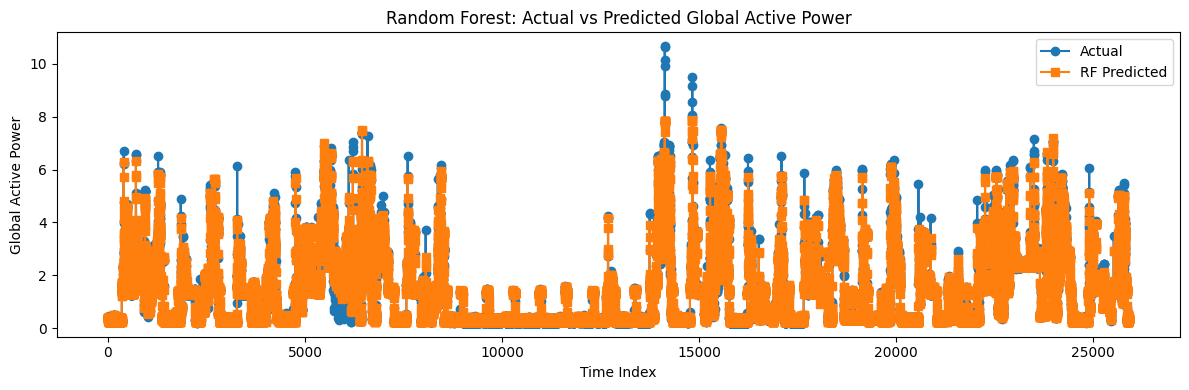

In [9]:
from sklearn.ensemble import RandomForestRegressor

# 13) Train a Random Forest regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 14) Predict and evaluate
y_rf_pred = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, y_rf_pred, squared=False)
rf_r2   = r2_score(y_test, y_rf_pred)
print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest R²:   {rf_r2:.4f}")

# 15) Plot RF actual vs. predicted
plt.figure(figsize=(12, 4))
plt.plot(y_test.values,     marker='o', label='Actual')
plt.plot(y_rf_pred,         marker='s', label='RF Predicted')
plt.title('Random Forest: Actual vs Predicted Global Active Power')
plt.xlabel('Time Index')
plt.ylabel('Global Active Power')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
importances = pd.Series(rf_model.feature_importances_, index=features)
print(importances.sort_values(ascending=False).head(5))


rolling_3h        0.993985
lag1              0.003153
Voltage           0.000838
Sub_metering_1    0.000806
Sub_metering_3    0.000363
dtype: float64
